# Clickbait classification with logistic regression and custom features

## Load clickbait data from Kaggle
This data consists of headlines classified as clickbait or not (regular news). Source site: https://www.kaggle.com/datasets/amananandrai/clickbait-dataset

In [ ]:
# Read in the dataset with pandas
# 0 corresponds to not clickbait, 1 has been judged as clickbait

import pandas as pd

# Set pandas to display entire texts in dataframes
pd.set_option('display.max_colwidth', None)

data = pd.read_csv('data/clickbait_data.csv')
data.info()
data.head()

## Split into training and test sets

In [ ]:
from sklearn.model_selection import train_test_split

test_size = int(0.1 * len(data))
train, test  = train_test_split(data, test_size=test_size, random_state=9)
print(len(train))
print(len(test))

## Extract unigram (raw bag-of-word count) features from the text data
As a reminder, this step converts each headline to a numeric vector of unigram counts (how many times each word type occurs).
"Training" the vectorizer means finding how many unique features (in this case, unique words) are in the training set. This sets the number of columns in the matrix.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

unigram_vectorizer = CountVectorizer(tokenizer=nltk.word_tokenize)
unigram_vectorizer.fit(train['headline']) # input is a list of strings (documents)
train_features = unigram_vectorizer.transform(train['headline'])
test_features = unigram_vectorizer.transform(test['headline'])

print(type(train_features))
print(train_features.shape) # prints (number of rows in the matrix, number of columns)
print(test_features.shape)  # prints (number of rows in the matrix, number of columns)

Now let's add a custom feature of our own design. Specifically, let's add the number of words. Who knows, maybe clickbait is often longer or shorter than real news headlines? First we'll calculate that feature as a vector of lengths, one for each document (headline).

In [ ]:
train['tokenized_headline'] = train['headline'].map(nltk.word_tokenize) # tokenization
train['num_words'] = train['tokenized_headline'].str.len()
train.head()

In [ ]:
test['tokenized_headline'] = test['headline'].map(nltk.word_tokenize) # tokenization
test['num_words'] = test['tokenized_headline'].str.len()

Let's plot the distribution of the number of words (length) across clickbait and non-clickbait in the training set using the `seaborn` package. If there seems to be a difference in lengths between clickbait and non-clickbait, this could be a useful feature for our model to learn to distinguish them.

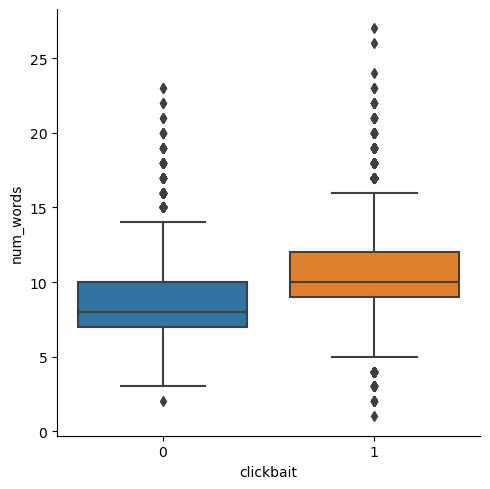

In [9]:
# View the distribution of lengths across clickbait and non-clickbait
import seaborn as sns

sns.catplot(data=train, x='clickbait', y='num_words', kind='box')

Let's combine the n-gram features with our new feature of word length. You can use the `scipy.sparse.hstack` function to combine the n-gram features (which are a `scipy` sparse matrices) with a the column of word lengths. In this way you are horizontally "stacking" new columns onto the matrix.

In [ ]:
import numpy as np
from scipy.sparse import hstack, csr_matrix

custom_train_feature = np.expand_dims(train['num_words'], axis=1) # make the new column a 2-dimensional NumPy array for concatenating with ngram features
custom_train_feature.shape

In [ ]:
print(train_features.shape) # original shape
custom_train_features = hstack([train_features, custom_train_feature])
print(custom_train_features.shape) # new shape

What is that new column in the training set features?

In [ ]:
# Add the feature to the test set, too

custom_test_feature = np.expand_dims(test['num_words'], axis=1) # make the new column a 2-dimensional NumPy array for concatenating with ngram features

print(test_features.shape) # original shape
custom_test_features = hstack([test_features, custom_test_feature])
print(custom_test_features.shape) # new shape

## Train and evaluate a logistic regression model for clickbait classification
We'll use `scikit-learn`'s `LogisticRegression` class to train 2 classifiers: one just using unigram features, and the other using unigram features **plus word lengths**.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_unigrams = LogisticRegression() # Instantiate a logistic regression classifier
clf_unigrams.fit(train_features, train['clickbait']) # Train the classifier

In [ ]:
clf_combined = LogisticRegression() # Instantiate a logistic regression classifier
clf_combined.fit(custom_train_features, train['clickbait']) # Train the classifier

In [ ]:
# Evaluate unigram logistic regression classifier
from sklearn.metrics import classification_report # this provides a bunch of useful evaluation metrics

test_labels = test['clickbait'] # true (gold) test set labels for clickbait/not clickbait
unigram_test_predictions = clf_unigrams.predict(test_features)

results = pd.DataFrame(classification_report(test_labels, unigram_test_predictions, output_dict=True))
results

In [ ]:
# Evaluate unigram + custom features logistic regression classifier

combined_test_predictions = clf_combined.predict(custom_test_features)
results = pd.DataFrame(classification_report(test_labels, combined_test_predictions, output_dict=True))
results

**Do you see any improvement from adding our custom feature?**

# Find most informative features from logistic regression
Logistic regression stores one model weight (parameter) per feature. We'll examine these learned feature weights to see which features are most strongly associated with each output class (clickbait and not clickbait).

In [ ]:
# This array is where the log probabilities of each feature for the positive class (clickbait) are stored
clf_combined.coef_.shape

**What does the number of columns in this matrix of coefficients (weights) correspond to?**  

Let's now rank the weights and list the features that correspond to the highest and lowest weights.

In [ ]:
def most_informative_features(vectorizer, classifier, class_id=1, n=10):
    feature_names = vectorizer.get_feature_names_out()
    if class_id == 1: # positive class
        topn = reversed(sorted(zip(classifier.coef_[0], feature_names))[-n:]) # take n features with highest weights
    else: # negative class
        topn = sorted(zip(classifier.coef_[0], feature_names))[:n] # take n features with lowest weights
    for coef, feat in topn:
        print(feat, coef)

In [ ]:
# Feel free to copy this cell for both positive (clickbait) and negative (not clickbait) classifiers
most_informative_features() # FILL IN the vectorizer, classifier and class_id you want to examine

Are any features surprising? Feel free to add more cells and try to investigate where some of these features occur in the training data. The pandas function `dataframe[col].str.contains(string)` may be helpful for this.